In [1]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Define file path and chunk size
file_path = "995,000_rows.csv"
chunksize = 25000

# Define your cleaning function
def clean_text(data):
    if not isinstance(data, str):  # Handle NaN values safely
        return ""
    data = data.lower()
    data = re.sub(r'\s+', " ", data)
    data = re.sub(r'\d{1,2}[./-]\d{1,2}[./-]\d{2,4}', "<DATE>", data)
    data = re.sub(r'(?:jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec).? \d{1,2},? \d{4}', "<DATE>", data)
    data = re.sub(r'\d{4}-\d{2}-\d{2}', "<DATE>", data)
    data = re.sub(r'[\w._%+-]+@[\w.-]+\.[a-zA-Z]{2,}', "<EMAIL>", data)
    data = re.sub(r'http[s]?://[^\s]+', "<URL>", data)
    data = re.sub(r'\d+(\.\d+)?', "<NUM>", data)
    return data

# Initialize stopwords and stemmer
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

# Define function to tokenize, remove stopwords, and stem
def tokenize_and_stem(text):
    tokens = word_tokenize(text)
    filtered_tokens = [ps.stem(word) for word in tokens if word.isalpha() and word not in stop_words]
    return filtered_tokens

# List of columns to process
columns_to_clean = ["Unamed: 0",
    "id", "domain", "type", "url", "content", "scraped_at", "inserted_at",
    "updated_at", "title", "authors", "keywords", "meta_keywords",
    "meta_description", "tags", "summary"
]

#Process and store all chunks in a single DataFrame
preprocessed_data = pd.DataFrame()

for chunk in pd.read_csv(file_path, chunksize=chunksize, low_memory=False):
    for col in columns_to_clean:
        if col in chunk.columns:
            # Clean
            chunk[col] = chunk[col].apply(clean_text)
            #Remove stopwords
            chunk[col] = chunk[col].astype(str).apply(
                lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words])
            )
            #Tokenize and stem
            chunk[col] = chunk[col].apply(tokenize_and_stem)
    # Append chunk to final DataFrame
    preprocessed_data = pd.concat([preprocessed_data, chunk], ignore_index=True)

# Save the final DataFrame to a CSV file
preprocessed_data.to_csv("cleaned_file.csv", index=False)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\emilv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\emilv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Total rows processed: 995000

Missing values in metadata columns (count):
authors             0
meta_keywords       0
meta_description    0
tags                0
summary             0
dtype: int64

Missing values in metadata columns (percentage):
authors             0.0
meta_keywords       0.0
meta_description    0.0
tags                0.0
summary             0.0
dtype: float64

Domain distribution (top 10):
[]                          988328
['num']                       3501
['thenet', 'num']             2085
['break', 'num']               636
['x', 'num']                   155
['revolut', 'num']              98
['bb', 'num']                   77
['williambanzai', 'num']        60
['presid', 'num']               34
['smag', 'num']                 13
dtype: int64

Total articles with 'error' in content: 81821

Content length statistics:
count    995000.000000
mean       2474.612128
std        3575.251400
min           2.000000
25%         587.000000
50%        1591.000000
75%        

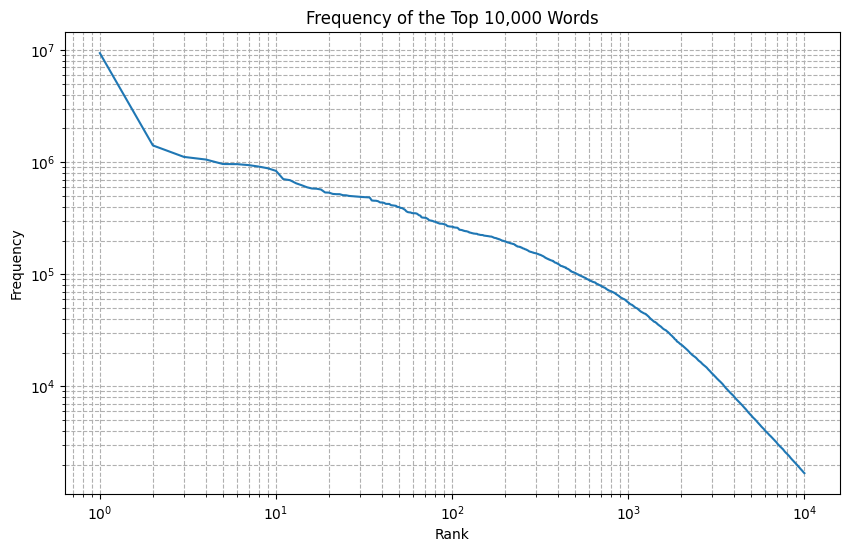

In [2]:
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt

cleaned_file = "cleaned_file.csv"
chunksize = 25000  

# Columns to analyze for missing metadata
metadata_cols = ['authors', 'meta_keywords', 'meta_description', 'tags', 'summary']

# Accumulators for initial observations
total_rows = 0
missing_counts_acc = None
domain_counts_acc = {}
error_count_acc = 0
content_lengths = []

# Accumulators for content analysis
total_urls = 0
total_dates = 0
total_numerics = 0
word_counter = Counter()

# Process the CSV in chunks
for chunk in pd.read_csv(cleaned_file, chunksize=chunksize, low_memory=False):
    total_rows += len(chunk)
    
    # Observation 1: Missing values for metadata columns 
    chunk_missing = chunk[metadata_cols].isnull().sum()
    if missing_counts_acc is None:
        missing_counts_acc = chunk_missing
    else:
        missing_counts_acc += chunk_missing

    # Observation 2: Domain distribution 
    chunk_domain_counts = chunk['domain'].value_counts()
    for domain, count in chunk_domain_counts.items():
        domain_counts_acc[domain] = domain_counts_acc.get(domain, 0) + count

    # Observation 3: Content Artifacts and Anomalies
    # Convert the 'content' column to string
    chunk['content'] = chunk['content'].astype(str)
    # Detect rows containing "error"
    error_mask = chunk['content'].str.contains(r"\berror\b", case=False, regex=True, na=False)
    error_count_acc += error_mask.sum()

    # Accumulate content lengths
    content_lengths.extend(chunk['content'].apply(len).tolist())
    
    # Counting URLs, dates, numeric values, and aggregating words
    # Inline regex patterns with (?i) for case-insensitive matching
    url_regex = r'(?i)https?://\S+'
    date_regex = r'(?i)\b(?:\d{1,2}[/-]\d{1,2}[/-]\d{2,4}|\d{4}-\d{2}-\d{2})\b'
    numeric_regex = r'\b\d+(?:\.\d+)?\b'
    word_regex = r'\w+'
    
    total_urls += chunk['content'].str.count(url_regex).sum()
    total_dates += chunk['content'].str.count(date_regex).sum()
    total_numerics += chunk['content'].str.count(numeric_regex).sum()
    
    # Aggregate word counts for the top frequent words
    combined_text = " ".join(chunk['content'].tolist())
    words = re.findall(word_regex, combined_text.lower())
    word_counter.update(words)

# Results after processing
print("Total rows processed:", total_rows)

print("\nMissing values in metadata columns (count):")
print(missing_counts_acc)
print("\nMissing values in metadata columns (percentage):")
print((missing_counts_acc / total_rows * 100).round(2))

print("\nDomain distribution (top 10):")
domain_series = pd.Series(domain_counts_acc).sort_values(ascending=False)
print(domain_series.head(10))

print("\nTotal articles with 'error' in content:", error_count_acc)

print("\nContent length statistics:")
print(pd.Series(content_lengths).describe())

# Additional content analysis results
print("\nTotal URLs found in content:", total_urls)
print("Total dates found in content:", total_dates)
print("Total numeric values found in content:", total_numerics)

# Top 100 most frequent words
top_100_words = word_counter.most_common(100)
print("\nTop 100 most frequent words:")
for word, count in top_100_words:
    print(f"{word}: {count}")

# Plot frequency of the top 10,000 most frequent words
top_10000 = word_counter.most_common(10000)
if top_10000:
    ranks = range(1, len(top_10000) + 1)
    frequencies = [freq for word, freq in top_10000]
    
    plt.figure(figsize=(10, 6))
    plt.plot(ranks, frequencies)
    plt.xlabel('Rank')
    plt.ylabel('Frequency')
    plt.title('Frequency of the Top 10,000 Words')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, which="both", ls="--")
    plt.show()
    
else:
    print("Not enough words to plot the top 10,000 frequencies.")

In [11]:
# Load the cleaned file
split_cleaned_file = pd.read_csv("cleaned_file.csv")
#Split dataset in 80% train and 10% test and 10% validation
training_data = split_cleaned_file.head(int(len(split_cleaned_file)*0.8))
remaining_data = split_cleaned_file.tail(int(len(split_cleaned_file)*0.2))
testing_data = remaining_data.head(int(len(split_cleaned_file)*0.1))
validation_data = remaining_data.tail(int(len(split_cleaned_file)*0.1))


#Print the shapes of the resulting datasets
print("Training data shape:", len(training_data))
print("Validation data shape:", len(validation_data))
print("Testing data shape:", len(testing_data))

C:\Users\emilv\AppData\Local\Temp\ipykernel_11400\3770604525.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  split_cleaned_file = pd.read_csv("cleaned_file.csv")


Training data shape: 796000
Validation data shape: 99500
Testing data shape: 99500
